<a href="https://colab.research.google.com/github/kvjc/Despacho-economico/blob/main/energy_offer_curve_colombia_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Despacho Económico del Mercado Eléctrico Colombiano
Análisis y visualización de datos de oferta, demanda y precios obtenidos de XM para modelar el despacho económico.

##Carga de datos
Se utilizan tres fuentes principales:
- Precios de oferta por planta
- Disponibilidad de oferta por planta y hora
- Proyección de demanda por hora

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#Load data
power_generation = "/content/drive/MyDrive/Análisis de mercados energéticos /datos/OFEI0404.txt"
power_priceMWh = "/content/drive/MyDrive/Análisis de mercados energéticos /datos/DPT0401.txt"

In [4]:
df_gen =  pd.read_csv(power_generation, sep = "\t")
df_price = pd.read_csv(power_priceMWh, sep = "\t")
df_price

,"SUNNORTE,86033"
0,"CARLOSLLERAS,87000"
1,"ESCUELADEMINAS,87000.01"
2,"PORTONDELSOL,88000"
3,"PARQUESOLARLAUNION,88000.01"
4,"LAMATA,88000.02"
...,...
108,"TEBSABCC33,2156381"
109,"TERMOCENTROCC22,2202671"
110,"TERMODORADA1,2306464"
111,"TERMOCENTROCC55,2595975"


##Procesamiento de datos

In [ ]:
import pandas as pd

def procesar_archivo_generation(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    data = []
    agente = None

    for line in lines:
        line = line.strip()
        if line.startswith("AGENTE:"):
            agente = line.replace("AGENTE:", "").strip()
        elif ',' in line:
            partes = [p.strip() for p in line.split(',')]
            planta = partes[0]
            tipo = partes[1]
            valores = partes[2:]

            for hora, valor in enumerate(valores):
                try:
                    valor_float = float(valor)
                    data.append({
                        'Agente': agente,
                        'Planta': planta,
                        'Tipo': tipo,
                        'Hora': hora,
                        'Valor': valor_float
                    })
                except ValueError:
                    continue

    df = pd.DataFrame(data)
    return df

In [ ]:
def procesar_archivo_price(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

  data = []

  for line in lines:
    line = line.strip()
    partes = [p.strip() for p in line.split(',')]
    nombre = partes[0]
    precio_str = partes[1]

    try:
        precio_float = float(precio_str)
        data.append({
            'Planta': nombre,
            'Precio': precio_float,
        })
    except ValueError:
        print(f"Could not convert '{precio_str}' to float for '{nombre}'")
        continue

  df_precio = pd.DataFrame(data)
  return df_precio



In [ ]:
df_gen = procesar_archivo_generation(power_generation)
df_gen.to_excel('datos_organizados_generation.xlsx', index=False)
df_gen

,Agente,Planta,Tipo,Hora,Valor
0,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,0,0.0
1,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,1,0.0
2,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,2,0.0
3,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,3,0.0
4,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,4,0.0
...,...,...,...,...,...
19273,YARUMO,PARQUESOLARBARANOA1,INVD,19,77.0
19274,YARUMO,PARQUESOLARBARANOA1,INVD,20,77.0
19275,YARUMO,PARQUESOLARBARANOA1,INVD,21,77.0
19276,YARUMO,PARQUESOLARBARANOA1,INVD,22,77.0


In [ ]:
df_price = procesar_archivo_price(power_priceMWh)
df_price.to_excel('datos_organizados_price.xlsx', index=False)
df_price

,Planta,Precio
0,SUNNORTE,86033.00
1,CARLOSLLERAS,87000.00
2,ESCUELADEMINAS,87000.01
3,PORTONDELSOL,88000.00
4,PARQUESOLARLAUNION,88000.01
...,...,...
109,TEBSABCC33,2156381.00
110,TERMOCENTROCC22,2202671.00
111,TERMODORADA1,2306464.00
112,TERMOCENTROCC55,2595975.00


In [ ]:
df_generacion_d = df_gen[df_gen['Tipo'] == 'D'].copy()
df_generacion_d

,Agente,Planta,Tipo,Hora,Valor
0,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,0,0.0
1,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,1,0.0
2,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,2,0.0
3,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,3,0.0
4,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,4,0.0
...,...,...,...,...,...
19249,YARUMO,PARQUESOLARBARANOA1,D,19,0.0
19250,YARUMO,PARQUESOLARBARANOA1,D,20,0.0
19251,YARUMO,PARQUESOLARBARANOA1,D,21,0.0
19252,YARUMO,PARQUESOLARBARANOA1,D,22,0.0


Lógica de despacho

In [ ]:
df_directo = pd.merge(df_generacion_d, df_price, how='inner', on='Planta')
df_directo.to_excel('datos_directo.xlsx', index=False)
df_directo

,Agente,Planta,Tipo,Hora,Valor,Precio
0,CELSIA COLOMBIA,MERILECTRICA1,D,0,164.0,1020762.0
1,CELSIA COLOMBIA,MERILECTRICA1,D,1,164.0,1020762.0
2,CELSIA COLOMBIA,MERILECTRICA1,D,2,164.0,1020762.0
3,CELSIA COLOMBIA,MERILECTRICA1,D,3,164.0,1020762.0
4,CELSIA COLOMBIA,MERILECTRICA1,D,4,164.0,1020762.0
...,...,...,...,...,...,...
643,TERMOYOPAL,TERMOYOPALG5,D,19,0.0,94500.0
644,TERMOYOPAL,TERMOYOPALG5,D,20,0.0,94500.0
645,TERMOYOPAL,TERMOYOPALG5,D,21,0.0,94500.0
646,TERMOYOPAL,TERMOYOPALG5,D,22,0.0,94500.0


In [ ]:
plantas_usadas = set(df_directo['Planta'])
df_restantes = df_generacion_d[~df_generacion_d['Planta'].isin(plantas_usadas)].copy()

df_restantes['planta_base'] = df_restantes['Planta'].str.extract(r'^([A-Z_]+)', expand=False)
df_restantes

,Agente,Planta,Tipo,Hora,Valor,planta_base
0,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,0,0.0,PLANTASOLARBAYUNCAI
1,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,1,0.0,PLANTASOLARBAYUNCAI
2,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,2,0.0,PLANTASOLARBAYUNCAI
3,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,3,0.0,PLANTASOLARBAYUNCAI
4,4E S.A.S E.S.P.,PLANTASOLARBAYUNCAI1,D,4,0.0,PLANTASOLARBAYUNCAI
...,...,...,...,...,...,...
19249,YARUMO,PARQUESOLARBARANOA1,D,19,0.0,PARQUESOLARBARANOA
19250,YARUMO,PARQUESOLARBARANOA1,D,20,0.0,PARQUESOLARBARANOA
19251,YARUMO,PARQUESOLARBARANOA1,D,21,0.0,PARQUESOLARBARANOA
19252,YARUMO,PARQUESOLARBARANOA1,D,22,0.0,PARQUESOLARBARANOA


In [ ]:
conteo_precios = df_price['Planta'].value_counts()
plantas_unicas_en_precios = conteo_precios[conteo_precios == 1].index

df_a_agrupar = df_restantes[
    (df_restantes['planta_base'].isin(plantas_unicas_en_precios)) &
    (~df_restantes['Planta'].isin(df_price['Planta']))
].copy()

df_a_agrupar

,Agente,Planta,Tipo,Hora,Valor,planta_base
96,AES COLOMBIA,CHIVOR1,D,0,125.0,CHIVOR
97,AES COLOMBIA,CHIVOR1,D,1,125.0,CHIVOR
98,AES COLOMBIA,CHIVOR1,D,2,125.0,CHIVOR
99,AES COLOMBIA,CHIVOR1,D,3,125.0,CHIVOR
100,AES COLOMBIA,CHIVOR1,D,4,125.0,CHIVOR
...,...,...,...,...,...,...
18793,URRA,URRA4,D,19,69.0,URRA
18794,URRA,URRA4,D,20,69.0,URRA
18795,URRA,URRA4,D,21,69.0,URRA
18796,URRA,URRA4,D,22,69.0,URRA


In [ ]:
df_agrupado = df_a_agrupar.groupby(['planta_base', 'Hora'])['Valor'].sum().reset_index()
df_agrupado

,planta_base,Hora,Valor
0,AMOYALAESPERANZA,0,75.0
1,AMOYALAESPERANZA,1,75.0
2,AMOYALAESPERANZA,2,75.0
3,AMOYALAESPERANZA,3,75.0
4,AMOYALAESPERANZA,4,75.0
...,...,...,...
955,URRA,19,207.0
956,URRA,20,207.0
957,URRA,21,207.0
958,URRA,22,207.0


In [ ]:
# Conservar solo las columnas necesarias en df_price
df_price_limpio = df_price[['Planta', 'Precio']].copy()

for col in ['Planta', 'Precio']:
    if col in df_agrupado.columns:
        df_agrupado.drop(columns=[col], inplace=True)

df_agrupado = pd.merge(df_agrupado, df_price_limpio, left_on='planta_base', right_on='Planta', how='left')

df_agrupado.drop(columns=['Planta'], inplace=True)
df_agrupado

,planta_base,Hora,Valor,Precio
0,AMOYALAESPERANZA,0,75.0,104575.0
1,AMOYALAESPERANZA,1,75.0,104575.0
2,AMOYALAESPERANZA,2,75.0,104575.0
3,AMOYALAESPERANZA,3,75.0,104575.0
4,AMOYALAESPERANZA,4,75.0,104575.0
...,...,...,...,...
955,URRA,19,207.0,250000.0
956,URRA,20,207.0,250000.0
957,URRA,21,207.0,250000.0
958,URRA,22,207.0,250000.0


In [ ]:
df_agrupado_final = df_agrupado.rename(columns={'planta_base': 'planta', 'Hora': 'hora','Valor': 'valor', 'Precio':'precio'})[['planta', 'hora', 'valor', 'precio']]


In [ ]:
df_directo.rename(columns={'Planta': 'planta', 'Hora': 'hora', 'Valor': 'valor', 'Precio': 'precio'}, inplace=True)

In [ ]:
df_directo_final = df_directo[['planta', 'hora', 'valor', 'precio']]
df_directo_final.to_excel('datos_directo_final.xlsx', index=False)
df_directo_final

,planta,hora,valor,precio
0,MERILECTRICA1,0,164.0,1020762.0
1,MERILECTRICA1,1,164.0,1020762.0
2,MERILECTRICA1,2,164.0,1020762.0
3,MERILECTRICA1,3,164.0,1020762.0
4,MERILECTRICA1,4,164.0,1020762.0
...,...,...,...,...
643,TERMOYOPALG5,19,0.0,94500.0
644,TERMOYOPALG5,20,0.0,94500.0
645,TERMOYOPALG5,21,0.0,94500.0
646,TERMOYOPALG5,22,0.0,94500.0


In [ ]:
diccionario_nombres_combinaciones = {
    "ALBAN": ["ALTOANCHICAYA", "BAJOANCHICAYA"],
    "GUATRON": ["TRONERAS", "GUATAPE"],
    "PAGUA": ["PARAISO", "LAGUACA"]
}

plantas_base_caso3 = sum(diccionario_nombres_combinaciones.values(), [])


import re

def limpiar_nombre(nombre):
    return re.sub(r'\d+', '', nombre).strip().upper()

df_caso3 = df_generacion_d[df_generacion_d['Planta'].apply(lambda x: limpiar_nombre(x) in plantas_base_caso3)].copy()

df_caso3['planta_base'] = df_caso3['Planta'].apply(limpiar_nombre)

# Columna planta_precio: buscamos la clave correspondiente
def obtener_planta_precio(base):
    for clave, lista in diccionario_nombres_combinaciones.items():
        if base in lista:
            return clave
    return base

df_caso3['planta_precio'] = df_caso3['planta_base'].apply(obtener_planta_precio)

df_caso3.head(5)

,Agente,Planta,Tipo,Hora,Valor,planta_base,planta_precio
1368,CELSIA COLOMBIA,ALTOANCHICAYA1,D,0,115.0,ALTOANCHICAYA,ALBAN
1369,CELSIA COLOMBIA,ALTOANCHICAYA1,D,1,115.0,ALTOANCHICAYA,ALBAN
1370,CELSIA COLOMBIA,ALTOANCHICAYA1,D,2,115.0,ALTOANCHICAYA,ALBAN
1371,CELSIA COLOMBIA,ALTOANCHICAYA1,D,3,115.0,ALTOANCHICAYA,ALBAN
1372,CELSIA COLOMBIA,ALTOANCHICAYA1,D,4,115.0,ALTOANCHICAYA,ALBAN


In [ ]:
if 'Planta' in df_caso3.columns:
    df_caso3 = df_caso3.drop(columns=['Planta'])

# Ahora sí hacemos el merge sin problemas
df_caso3 = pd.merge(
    df_caso3,
    df_price[['Planta', 'Precio']],
    left_on='planta_precio',
    right_on='Planta',
    how='left'
)



In [ ]:
df_caso3.rename(columns={'Hora': 'hora', 'Valor': 'valor', 'Precio': 'precio', 'planta_base': 'planta'}, inplace=True)

In [ ]:
# Nos aseguramos de tener solo las columnas correctas y con los nombres correctos
df_caso3_limpio = df_caso3[['planta', 'hora', 'valor', 'precio']].copy()


In [ ]:
# Paso 8: Unir ambos resultados
df_final = pd.concat([df_directo_final, df_agrupado_final], ignore_index=True)

In [ ]:
# Unimos ambos DataFrames
df_final = pd.concat([df_final, df_caso3_limpio], ignore_index=True)


In [ ]:
df_final

,planta,hora,valor,precio
0,MERILECTRICA1,0,164.0,1020762.0
1,MERILECTRICA1,1,164.0,1020762.0
2,MERILECTRICA1,2,164.0,1020762.0
3,MERILECTRICA1,3,164.0,1020762.0
4,MERILECTRICA1,4,164.0,1020762.0
...,...,...,...,...
2155,TRONERAS,19,20.0,103760.0
2156,TRONERAS,20,20.0,103760.0
2157,TRONERAS,21,20.0,103760.0
2158,TRONERAS,22,20.0,103760.0


In [ ]:
df_total_20h = df_final[df_final['hora'] == 20].copy()
df_total_20h

,planta,hora,valor,precio
20,MERILECTRICA1,20,164.0,1020762.0
44,PAIPA4,20,165.0,274265.0
68,ZIPAEMG2,20,36.0,371000.0
92,ZIPAEMG3,20,0.0,344000.0
116,ZIPAEMG4,20,64.0,357000.0
...,...,...,...,...
2060,GUATAPE,20,70.0,103760.0
2084,GUATAPE,20,70.0,103760.0
2108,GUATAPE,20,70.0,103760.0
2132,TRONERAS,20,20.0,103760.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

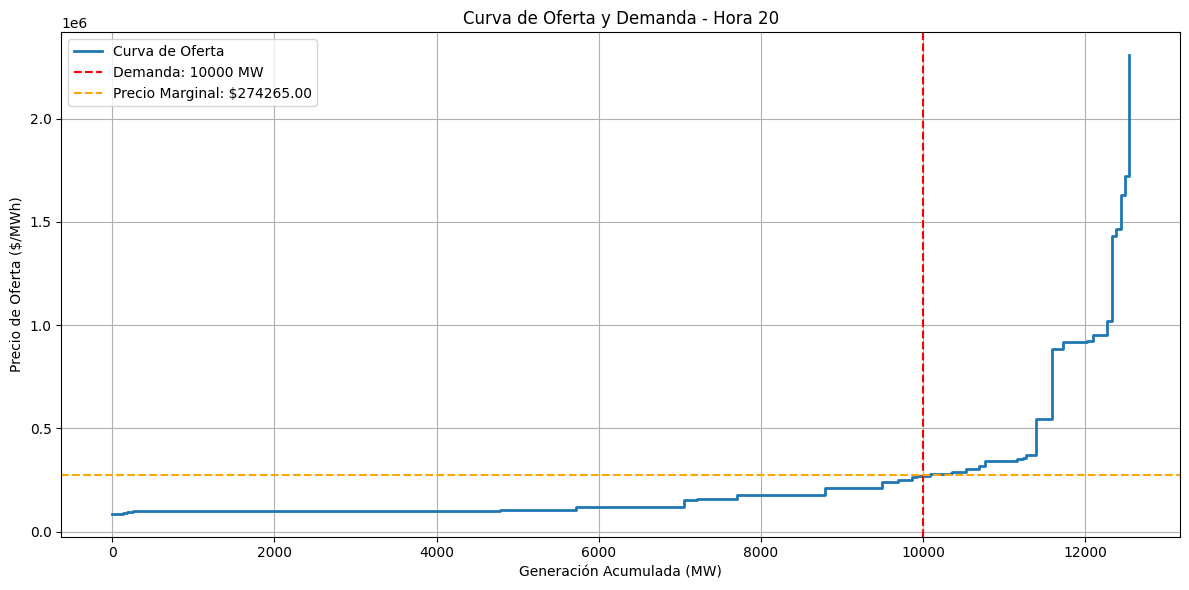

In [ ]:
import matplotlib.pyplot as plt

df_hora20 = df_total_20h[df_total_20h['hora'] == 20].copy()
df_hora20 = df_hora20.sort_values(by='precio')
df_hora20['Generacion_acumulada'] = df_hora20['valor'].cumsum()

demanda_hora20 = 10000

plt.figure(figsize=(12, 6))
plt.step(df_hora20['Generacion_acumulada'], df_hora20['precio'], where='post', label='Curva de Oferta', linewidth=2)
plt.axvline(demanda_hora20, color='red', linestyle='--', label=f'Demanda: {demanda_hora20} MW')

precio_marginal = df_hora20[df_hora20['Generacion_acumulada'] >= demanda_hora20].iloc[0]['precio']
plt.axhline(precio_marginal, color='orange', linestyle='--', label=f'Precio Marginal: ${precio_marginal:.2f}')

plt.title('Curva de Oferta y Demanda - Hora 20')
plt.xlabel('Generación Acumulada (MW)')
plt.ylabel('Precio de Oferta ($/MWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-29-1128378049.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


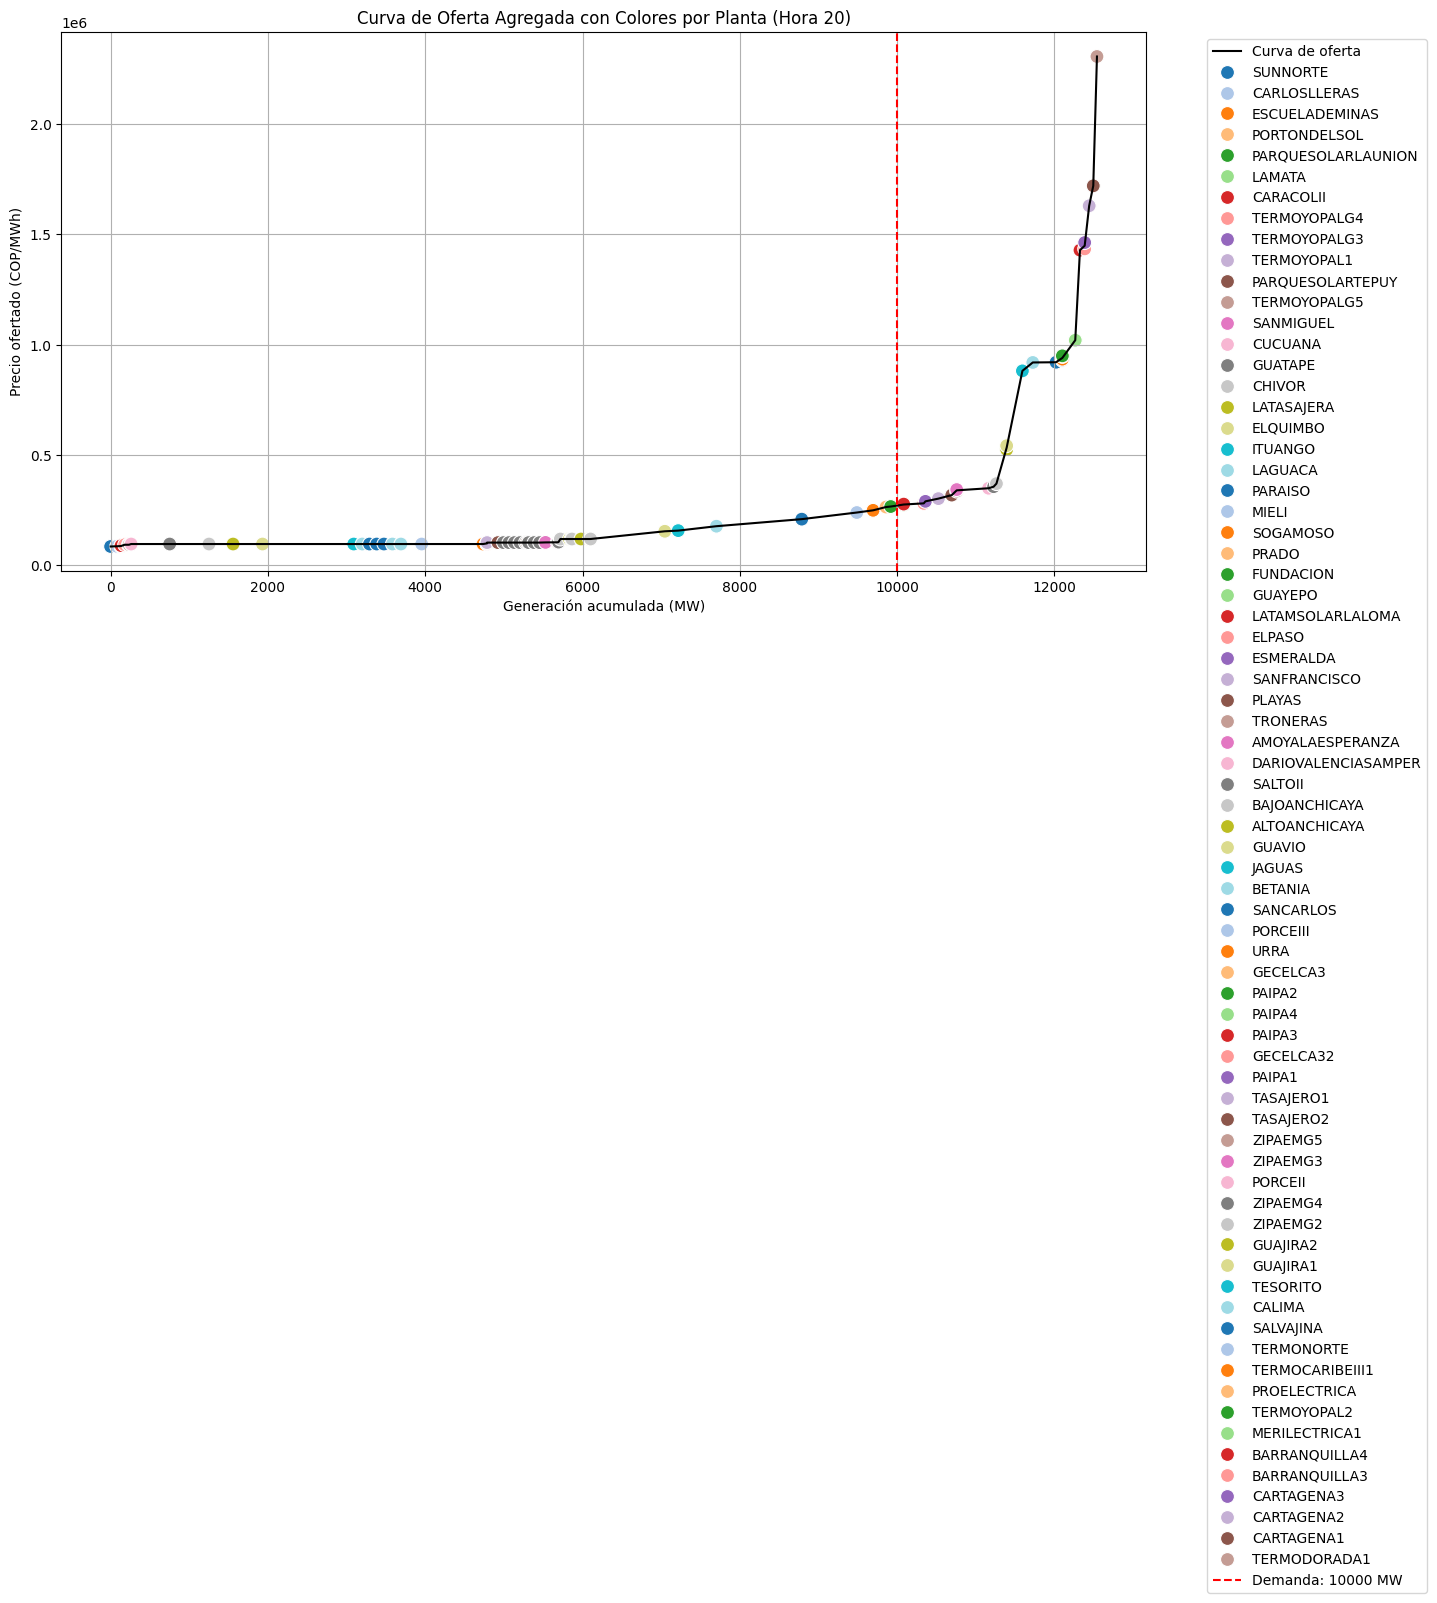

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_20hrs_sorted = df_total_20h.sort_values(by='precio')

df_20hrs_sorted['generacion_acumulada'] = df_20hrs_sorted['valor'].cumsum()

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_20hrs_sorted,
    x='generacion_acumulada',
    y='precio',
    color='black',
    label='Curva de oferta'
)

sns.scatterplot(
    data=df_20hrs_sorted,
    x='generacion_acumulada',
    y='precio',
    hue='planta',
    s=100,
    palette='tab20',
    legend='brief'
)

demanda_hora20 = 10000
plt.axvline(demanda_hora20, color='red', linestyle='--', label=f'Demanda: {demanda_hora20} MW')


plt.title('Curva de Oferta Agregada con Colores por Planta (Hora 20)')
plt.xlabel('Generación acumulada (MW)')
plt.ylabel('Precio ofertado (COP/MWh)')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
df_20hrs_sorted

,planta,hora,valor,precio,generacion_acumulada
1532,SUNNORTE,20,0.0,86033.00,0.00
764,CARLOSLLERAS,20,78.0,87000.00,78.00
908,ESCUELADEMINAS,20,55.0,87000.01,133.00
1316,PORTONDELSOL,20,0.0,88000.00,133.00
1196,PARQUESOLARLAUNION,20,0.0,88000.01,133.00
...,...,...,...,...,...
428,BARRANQUILLA3,20,60.0,1434681.00,12384.35
404,CARTAGENA3,20,0.0,1463352.00,12384.35
380,CARTAGENA2,20,57.0,1630037.00,12441.35
356,CARTAGENA1,20,52.0,1720425.00,12493.35


In [ ]:
df_despacho = df_20hrs_sorted.copy()

df_despacho['despachada'] = False
df_despacho.loc[df_despacho['generacion_acumulada'] <= 10000, 'despachada'] = True

idx_marginal = df_despacho[df_despacho['generacion_acumulada'] >= 10000].head(1).index
if not idx_marginal.empty:
    df_despacho.loc[idx_marginal, 'despachada'] = True
    precio_marginal = df_despacho.loc[idx_marginal[0], 'precio']
else:
    precio_marginal = df_despacho['precio'].max()

tabla_resultado = df_despacho[['planta', 'valor', 'precio', 'generacion_acumulada', 'despachada']]

import pandas as pd
pd.set_option('display.max_rows', None)

print(f"🔹 Precio marginal de la hora 20: {precio_marginal} $/MWh")
tabla_resultado.reset_index(drop=True, inplace=True)
tabla_resultado.head(3)


🔹 Precio marginal de la hora 20: 274265.0 $/MWh


,planta,valor,precio,generacion_acumulada,despachada
0,SUNNORTE,0.0,86033.00,0.0,True
1,CARLOSLLERAS,78.0,87000.00,78.0,True
2,ESCUELADEMINAS,55.0,87000.01,133.0,True


In [ ]:
df_filtrado = df_20hrs_sorted[df_20hrs_sorted['valor'] > 0].copy()

df_filtrado = df_filtrado.sort_values(by='precio')
df_filtrado['generacion_acumulada'] = df_filtrado['valor'].cumsum()

df_filtrado['despachada'] = False
df_filtrado.loc[df_filtrado['generacion_acumulada'] <= 10000, 'despachada'] = True

idx_marginal = df_filtrado[df_filtrado['generacion_acumulada'] >= 10000].head(1).index
if not idx_marginal.empty:
    df_filtrado.loc[idx_marginal, 'despachada'] = True
    precio_marginal = df_filtrado.loc[idx_marginal[0], 'precio']
else:
    precio_marginal = df_filtrado['precio'].max()

tabla_final = df_filtrado[['planta', 'valor', 'precio', 'generacion_acumulada', 'despachada']].reset_index(drop=True)

print(f"🔹 Precio marginal de la hora 20 (sin plantas con valor 0): {precio_marginal} $/MWh")
tabla_final


🔹 Precio marginal de la hora 20 (sin plantas con valor 0): 274265.0 $/MWh


,planta,valor,precio,generacion_acumulada,despachada
0,CARLOSLLERAS,78.00,87000.00,78.00,True
1,ESCUELADEMINAS,55.00,87000.01,133.00,True
2,TERMOYOPALG4,46.00,94000.00,179.00,True
3,TERMOYOPALG3,49.00,94000.01,228.00,True
4,TERMOYOPAL1,8.00,94000.02,236.00,True
5,SANMIGUEL,25.00,97238.00,261.00,True
6,GUATAPE,490.00,97238.02,751.00,True
7,CHIVOR,500.00,97238.03,1251.00,True
8,LATASAJERA,306.00,97238.04,1557.00,True
9,ELQUIMBO,374.00,97238.05,1931.00,True


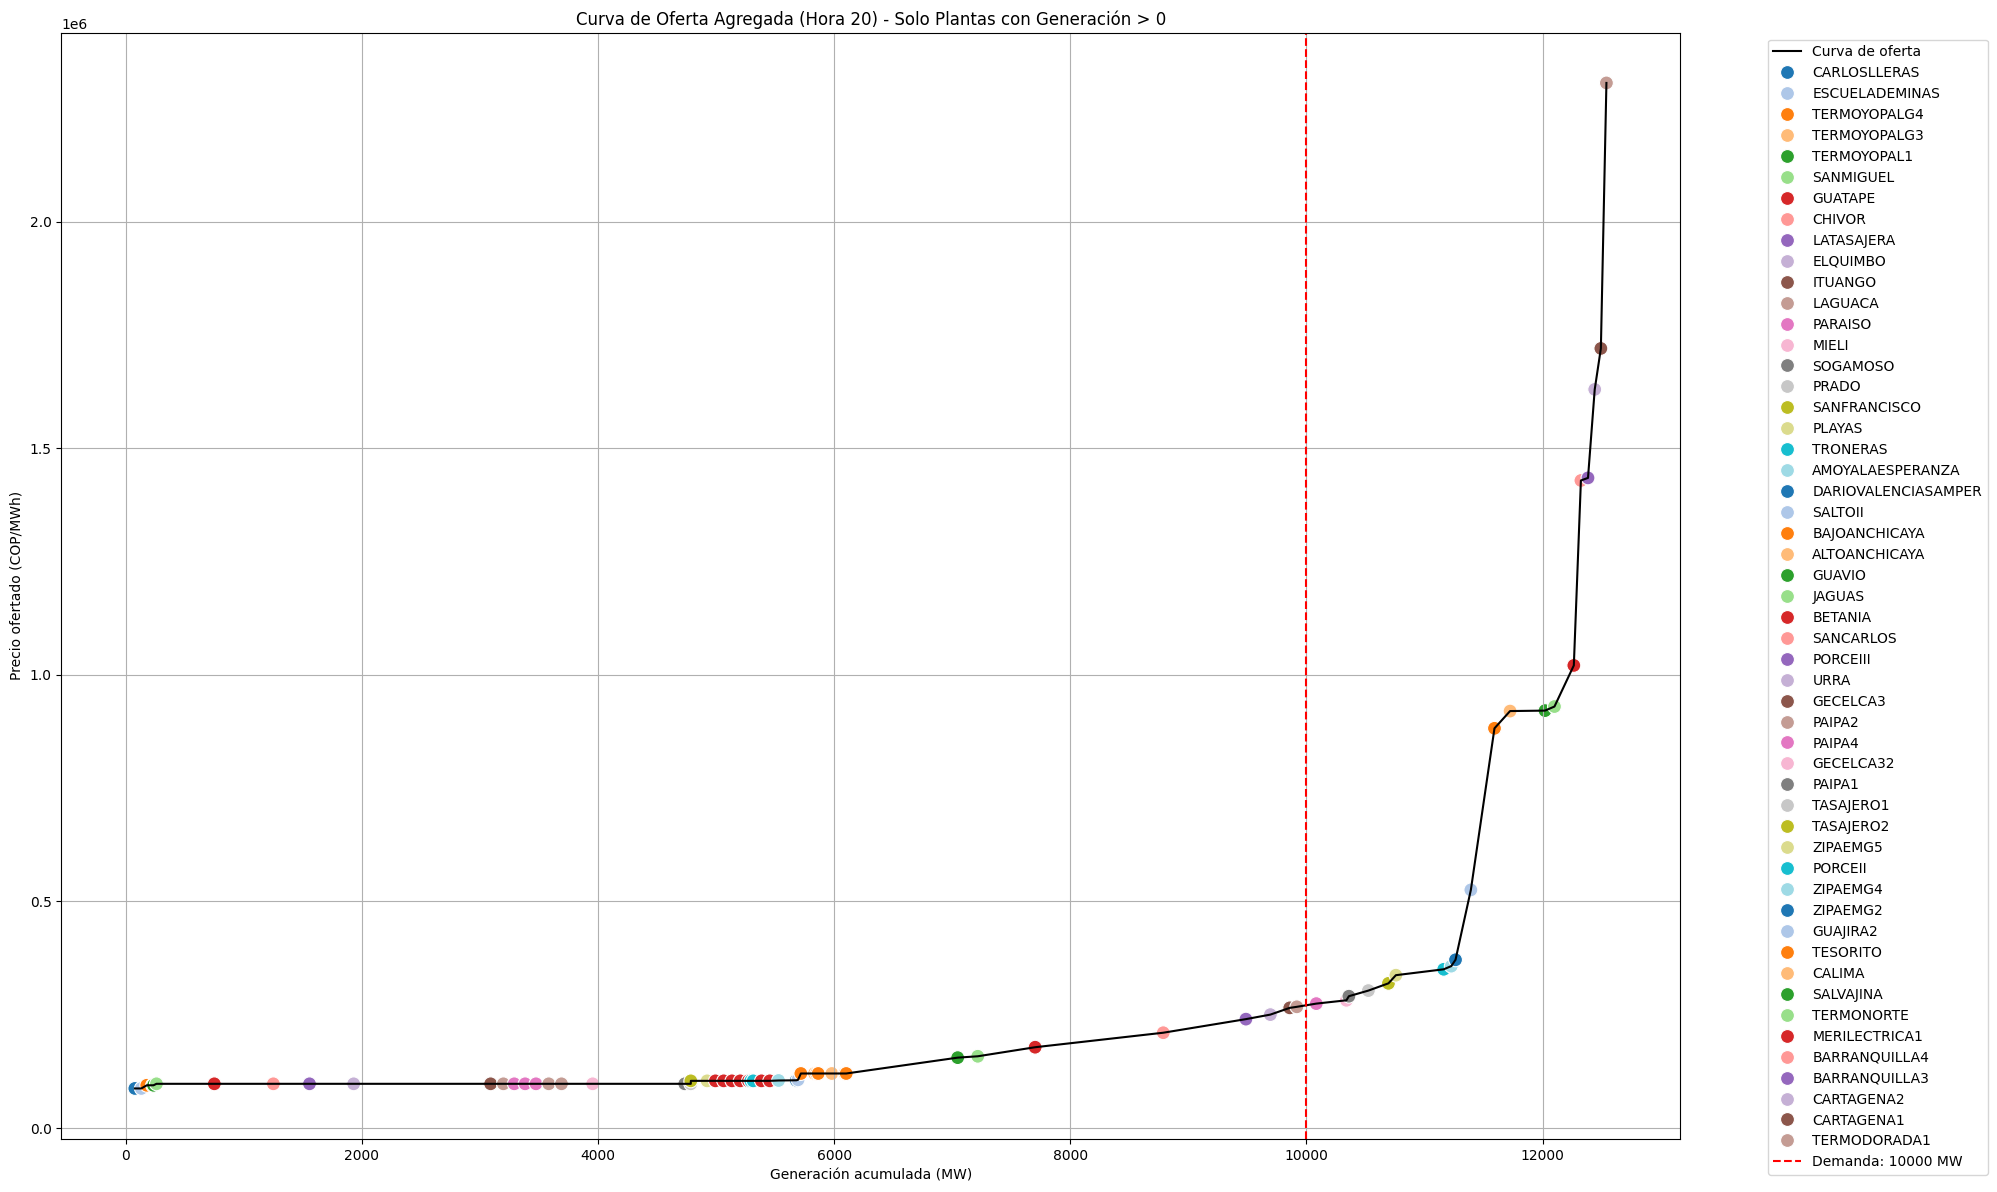

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_filtrado = df_filtrado.sort_values(by='precio')

df_filtrado['generacion_acumulada'] = df_filtrado['valor'].cumsum()

plt.figure(figsize=(17, 13))

sns.lineplot(
    data=df_filtrado,
    x='generacion_acumulada',
    y='precio',
    color='black',
    label='Curva de oferta'
)

sns.scatterplot(
    data=df_filtrado,
    x='generacion_acumulada',
    y='precio',
    hue='planta',
    s=100,
    palette='tab20',
    legend='brief'
)

demanda_hora20 = 10000
plt.axvline(demanda_hora20, color='red', linestyle='--', label=f'Demanda: {demanda_hora20} MW')

plt.title('Curva de Oferta Agregada (Hora 20) - Solo Plantas con Generación > 0')
plt.xlabel('Generación acumulada (MW)')
plt.ylabel('Precio ofertado (COP/MWh)')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


##Conclusiones
Durante el análisis del despacho económico se identificaron varios aspectos clave que deben ser considerados para obtener resultados más precisos y realistas:

- Normalización de nombres de plantas: Algunas plantas aparecen con nombres diferentes (por ejemplo, x1, x2) pero corresponden a una misma unidad o grupo de generación, ya que comparten el mismo precio de oferta. Es necesario unificarlas para evitar distorsiones en el análisis.

- Presencia de nombres combinados: Existen plantas con nombres compuestos o inconsistentes que requieren limpieza o estandarización para asegurar una correcta identificación y agrupación.

- Participación parcial en el despacho: Aunque algunas plantas tienen precios bajos, no siempre son despachadas con toda su disponibilidad. Esto puede deberse a restricciones técnicas, límites en la red o a que otras plantas con menor costo marginal cubren la demanda antes.

- Filtrado de ofertas irrelevantes: También se observan ofertas con precios muy bajos que, en la práctica, no reflejan participación real o efectiva en el despacho. Estas deben ser filtradas cuidadosamente para no afectar los resultados.

En conjunto, estas observaciones permiten refinar el análisis y aproximarse mejor al comportamiento real del sistema, haciendo más útil el modelo para simulaciones y toma de decisiones.